In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

def evaluate_embedding_unlabeled(embedding, batch_labels, cluster_labels=None, k=30):
    results = {}

    sil_batch = silhouette_score(embedding, batch_labels)
    results["Silhouette_batch"] = sil_batch

    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    indices = nbrs.kneighbors(return_distance=False)[:, 1:]
    batch_labels = np.array(batch_labels)
    entropies = []
    for idxs in indices:
        local_batches = batch_labels[idxs]
        counts = pd.Series(local_batches).value_counts(normalize=True)
        entropies.append(entropy(counts))
    results["Neighborhood_entropy"] = np.mean(entropies)

    if cluster_labels is not None:
        sil_cluster = silhouette_score(embedding, cluster_labels)
        results["Silhouette_cluster"] = sil_cluster

    return results


def benchmark_integration(
    adata, embedding_key="X_scVI", batch_key="batch", cluster_key="leiden", k=30
):
    sc.pp.neighbors(adata, use_rep=embedding_key)
    sc.tl.leiden(adata, key_added=cluster_key)

    embedding = adata.obsm[embedding_key]
    batches = adata.obs[batch_key].values
    clusters = adata.obs[cluster_key].values

    return evaluate_embedding_unlabeled(embedding, batches, clusters, k)


if __name__ == "__main__":
    # 路径修改为你本地的实际路径
    input_file = "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi.h5ad"

    adata = sc.read_h5ad(input_file)
    result = benchmark_integration(adata)

    print("Benchmark Results:")
    for key, val in result.items():
        print(f"{key}: {val:.4f}")


/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


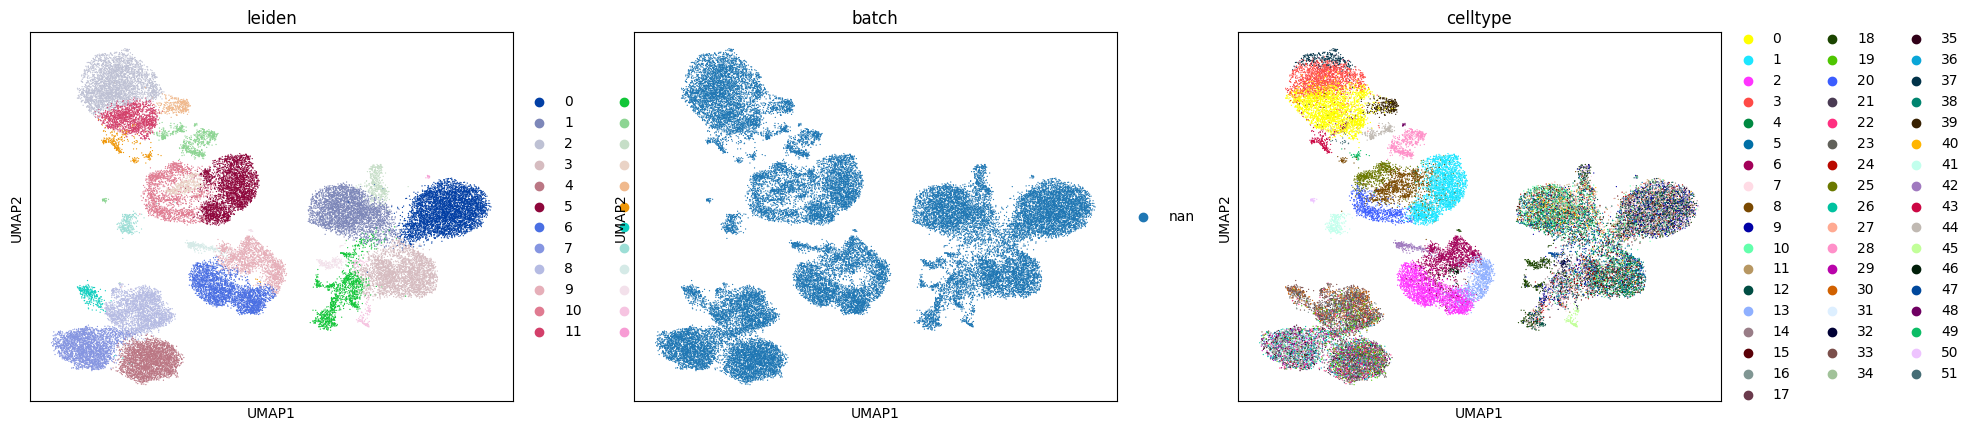

In [5]:
# 1. 构图 + 聚类
adata = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype.h5ad")
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden")  # 你也可以指定 resolution=0.5

# 2. 可视化
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "batch", "celltype"])

# 3. 保存
adata.write("bonemarrow_merged_scvi_with_celltype_and_leiden.h5ad")



In [8]:
# Benchmark integration results using pseudo celltype labels (e.g., Harmony-derived clustering)

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Load preprocessed .h5ad files (with celltype from Harmony transferred)
data_paths = {
    "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype.h5ad",
    "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden.h5ad"
    # "Seurat": "/root/Desktop/my_pan/workspace/Data/h5ad_output/merged_bone_marrow_batches_seurat_pca_with_celltype.h5ad"
}

# Define key mappings
embedding_keys = {
    "Harmony": "X_pca",
    "scVI": "X_scVI",
    # "Seurat": "X_pca"
}
cluster_keys = {
    "Harmony": "leiden",
    "scVI": "leiden"
    # "Seurat": "leiden"
}

# Benchmark function

def benchmark_with_celltype(embedding, celltype_labels, cluster_labels):
    results = {}
    results["Silhouette_celltype"] = silhouette_score(embedding, celltype_labels) if len(set(celltype_labels)) > 1 else np.nan
    results["ARI"] = adjusted_rand_score(celltype_labels, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    results["NMI"] = normalized_mutual_info_score(celltype_labels, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    return results

# Run benchmark across methods
all_results = {}
for method, path in data_paths.items():
    adata = sc.read_h5ad(path)
    embedding = adata.obsm[embedding_keys[method]]
    celltypes = adata.obs["celltype"]
    clusters = adata.obs[cluster_keys[method]]
    all_results[method] = benchmark_with_celltype(embedding, celltypes, clusters)

# Convert results to DataFrame
results_df = pd.DataFrame(all_results).T
results_df.to_csv("/root/Desktop/my_pan/workspace/Data/integration_celltype_benchmark.csv")
print("✅ Celltype-based benchmark results saved.")


✅ Celltype-based benchmark results saved.


In [34]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# === 1. 读取数据路径 ===
data_paths = {
    "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype_rebatch.h5ad",
    "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden_rebatch.h5ad",
    "scAtlasVAE": "/root/Desktop/my_pan/workspace/Data/h5ad_output/newb_merged_bonemarrow_batches_scatlasvae_full_with_celltype.h5ad"
}

# === 2. obsm/obs 列名映射 ===
embedding_keys = {
    "Harmony": "X_pca",
    "scVI": "X_scVI",
    "scAtlasVAE": "X_scatlasvae"
}
cluster_keys = {
    "Harmony": "leiden",
    "scVI": "leiden",
    "scAtlasVAE": "leiden"
}


In [31]:
import scanpy as sc

# 需要修改的两个文件路径
target_paths = {
    "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype.h5ad",
    "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden.h5ad"
}

for method, path in target_paths.items():
    adata = sc.read_h5ad(path)
    
    # 重新提取 batch 信息：从细胞名中取前缀（例如 BoneMarrow_1）
    adata.obs["batch"] = adata.obs_names.str.split(".").str[0]
    print(f"✅ [{method}] 已从细胞名前缀提取 batch，共提取 {adata.obs['batch'].nunique()} 个批次")

    # 保存新文件
    new_path = path.replace(".h5ad", "_rebatch.h5ad")
    adata.write(new_path)
    print(f"💾 [{method}] 保存为：{new_path}")


✅ [Harmony] 已从细胞名前缀提取 batch，共提取 6 个批次
💾 [Harmony] 保存为：/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype_rebatch.h5ad
✅ [scVI] 已从细胞名前缀提取 batch，共提取 6 个批次
💾 [scVI] 保存为：/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden_rebatch.h5ad


/tmp/ipykernel_4712/1555497630.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


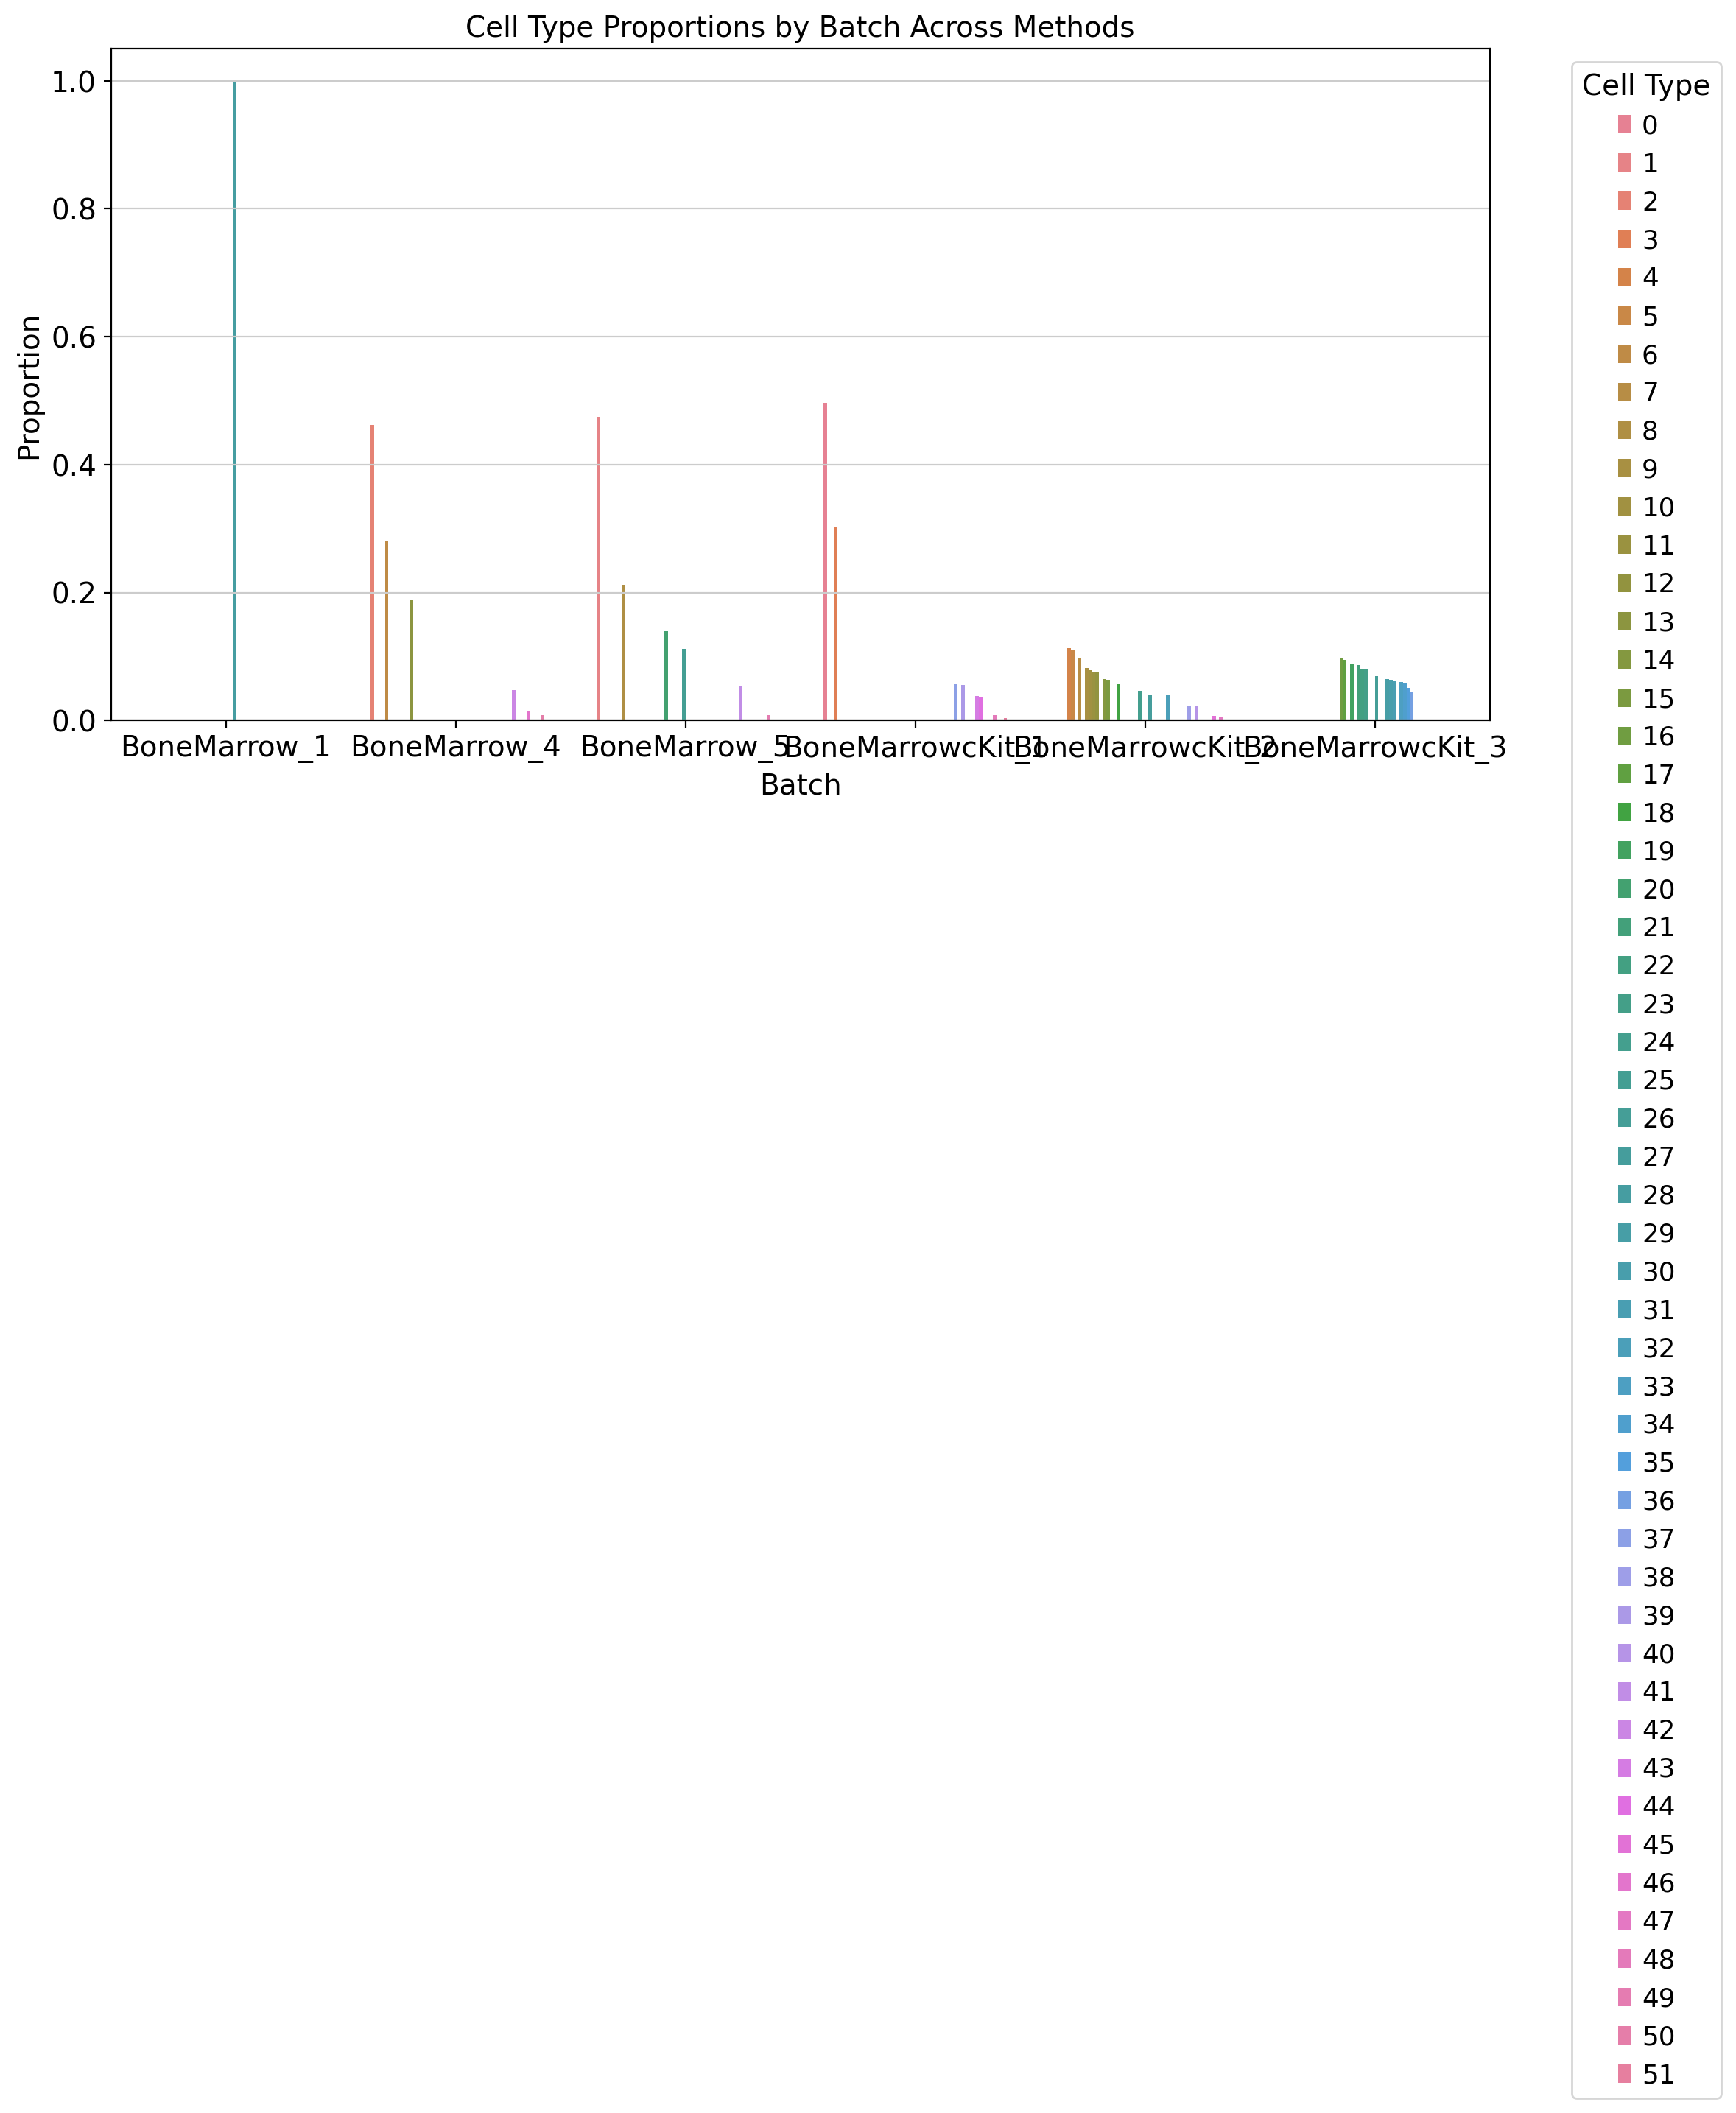

In [40]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 载入数据路径
data_paths = {
    "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype_rebatch.h5ad",
    "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden_rebatch.h5ad",
    "scAtlasVAE": "/root/Desktop/my_pan/workspace/Data/h5ad_output/newb_merged_bonemarrow_batches_scatlasvae_full_with_celltype.h5ad"
}

# 2. 处理每个 AnnData 的比例信息
def extract_celltype_proportions(h5ad_path, method_name):
    adata = sc.read_h5ad(h5ad_path)
    df = pd.crosstab(adata.obs["batch"], adata.obs["celltype"], normalize="index")
    df = df.reset_index().melt(id_vars="batch", var_name="celltype", value_name="proportion")
    df["method"] = method_name
    return df

dfs = []
for method, path in data_paths.items():
    df = extract_celltype_proportions(path, method)
    dfs.append(df)

df_all = pd.concat(dfs)

# 3. 绘图
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x="batch", y="proportion", hue="celltype")
plt.title("Cell Type Proportions by Batch Across Methods")
plt.xlabel("Batch")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cell Type")
plt.tight_layout()
plt.savefig("figure_S3_celltype_proportion_by_batch.png", dpi=300)
plt.show()


In [35]:
for method, path in data_paths.items():
    adata = sc.read_h5ad(path)
    print(f"🔍 {method} obsm keys:", adata.obsm.keys())


🔍 Harmony obsm keys: KeysView(AxisArrays with keys: X_harmony, X_pca, X_umap)
🔍 scVI obsm keys: KeysView(AxisArrays with keys: X_scVI, X_umap)
🔍 scAtlasVAE obsm keys: KeysView(AxisArrays with keys: X_scatlasvae, X_umap)


In [36]:
required_cols = ["batch", "celltype", "leiden"]
missing_cols = [col for col in required_cols if col not in adata.obs.columns]
if missing_cols:
    print("❗️ 缺失以下 obs 列:", missing_cols)
else:
    print("✅ 所有必要的 obs 列均已存在:", required_cols)

✅ 所有必要的 obs 列均已存在: ['batch', 'celltype', 'leiden']


In [37]:

# === 3. 手写 graph iLISI 函数 ===
def compute_graph_ilisi(embedding, batch_labels, k=30):
    nn = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    _, indices = nn.kneighbors(embedding)
    ilisi_scores = []
    for i, neighbors in enumerate(indices):
        neighbors = neighbors[1:]  # remove self
        labels = batch_labels[neighbors]
        counts = Counter(labels)
        total = sum(counts.values())
        p = np.array([c / total for c in counts.values()])
        simpson = np.sum(p ** 2)
        ilisi = 1 / simpson
        ilisi_scores.append(ilisi)
    return np.mean(ilisi_scores)

# === 4. Benchmark 函数（含 silhouette + ARI/NMI + iLISI） ===
def benchmark_with_celltype(embedding, celltype_labels, cluster_labels, batch_labels):
    results = {}
    results["Silhouette_celltype"] = silhouette_score(embedding, celltype_labels) if len(set(celltype_labels)) > 1 else np.nan
    results["ARI"] = adjusted_rand_score(celltype_labels, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    results["NMI"] = normalized_mutual_info_score(celltype_labels, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    results["graph_iLISI"] = compute_graph_ilisi(embedding, batch_labels)
    return results

# === 5. 批量运行所有方法 ===
all_results = {}
for method, path in data_paths.items():
    adata = sc.read_h5ad(path)
    embedding = adata.obsm[embedding_keys[method]]
    celltypes = adata.obs["celltype"]
    clusters = adata.obs[cluster_keys[method]]
    batch_labels = adata.obs["batch"].values
    all_results[method] = benchmark_with_celltype(embedding, celltypes, clusters, batch_labels)

# === 6. 输出为 CSV 表格 ===
results_df = pd.DataFrame(all_results).T
results_df.to_csv("/root/Desktop/my_pan/workspace/Data/integration_celltype_benchmark_with_ilisi.csv")
print("✅ Celltype-based benchmark results with graph iLISI saved.")


✅ Celltype-based benchmark results with graph iLISI saved.


In [6]:
print("Batch labels:", adata.obs["batch"].unique())
print("Leiden clusters:", adata.obs["leiden"].unique())


Batch labels: ['nan']
Categories (1, object): ['nan']
Leiden clusters: ['28', '6', '13', '2', '50', ..., '31', '21', '29', '23', '36']
Length: 52
Categories (52, object): ['0', '1', '2', '3', ..., '48', '49', '50', '51']


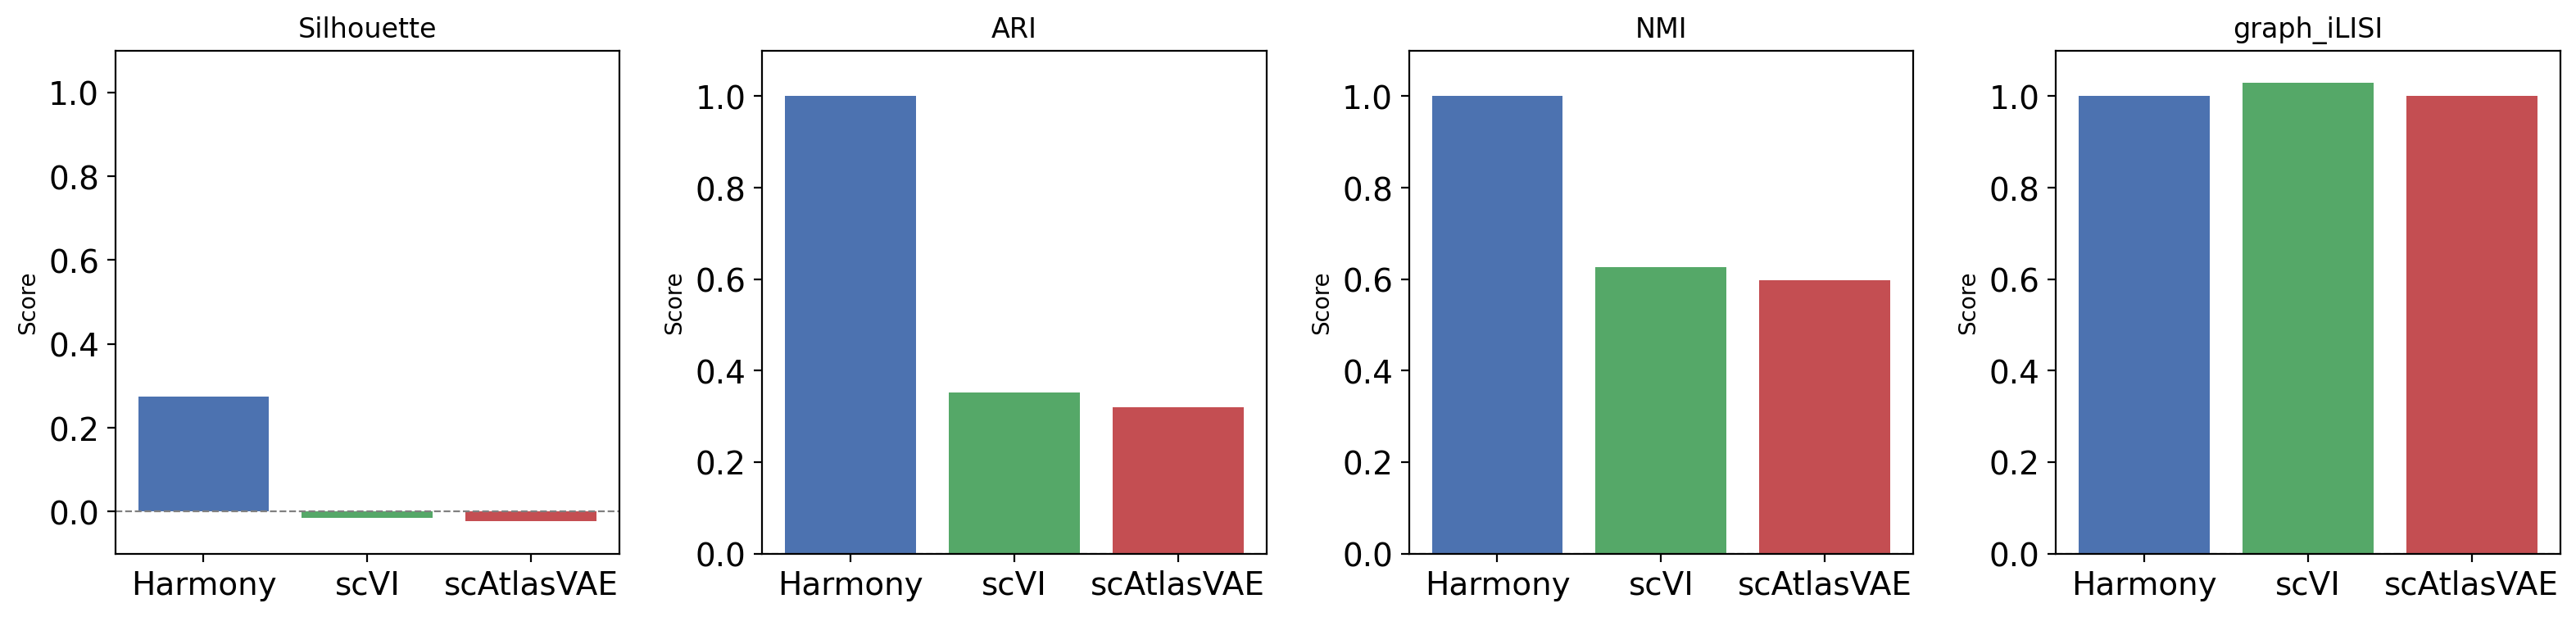

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 最新数据
data = {
    "Method": ["Harmony", "scVI", "scAtlasVAE"],
    "Silhouette": [0.27526, -0.01487, -0.02327],
    "ARI": [1.0, 0.35224, 0.32059],
    "NMI": [1.0, 0.62598, 0.59747],
    "graph_iLISI": [1.0, 1.02895, 1.0]
}

df = pd.DataFrame(data)
df.set_index("Method", inplace=True)

# 绘图
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=False)
metrics = df.columns
colors = ["#4C72B0", "#55A868", "#C44E52"]

for i, metric in enumerate(metrics):
    axs[i].bar(df.index, df[metric], color=colors)
    axs[i].set_title(metric, fontsize=12)
    axs[i].set_ylabel("Score", fontsize=10)
    axs[i].set_ylim(-0.1 if metric == "Silhouette" else 0, 1.1)
    axs[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].grid(False)  # 关键：关闭网格线

plt.tight_layout()
plt.savefig("figure1_no_grid.png", dpi=300)
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 示例以 Harmony 为例，scVI 和 scAtlasVAE 同理重复
def plot_celltype_distribution(adata, method):
    df = pd.crosstab(adata.obs["batch"], adata.obs["celltype"], normalize='index')
    df = df.reset_index().melt(id_vars="batch", var_name="celltype", value_name="proportion")
    df["method"] = method
    return df

dfs = []
dfs.append(plot_celltype_distribution(adata_harmony, "Harmony"))
dfs.append(plot_celltype_distribution(adata_scvi, "scVI"))
dfs.append(plot_celltype_distribution(adata_scatlasvae, "scAtlasVAE"))

df_all = pd.concat(dfs)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_all, x="batch", y="proportion", hue="celltype")
plt.title("Cell Type Proportions by Batch (Combined Across Methods)")
plt.tight_layout()
plt.savefig("figure_S3_celltype_proportion.png", dpi=300)
plt.close()


In [7]:
import scanpy as sc
 # "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype.h5ad",
    # "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype.h5ad"
adata1 = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype.h5ad")
print(adata1.obs.columns)  # 列出所有 obs 的列名
adata2 = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype.h5ad")
print(adata2.obs.columns)  # 列出所有 obs 的列名

Index(['batch', 'leiden', 'celltype'], dtype='object')
Index(['batch', '_scvi_batch', '_scvi_labels', 'celltype'], dtype='object')
